In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv


In [1]:
import numpy as np # linear algebra
import pandas as pd
train =pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
#test = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
#df_test = test['comment_text']
df = train[['target','comment_text']]

In [2]:
from imblearn.under_sampling import RandomUnderSampler
X = df['comment_text']
X = X.values.reshape(-1,1)
y = df['target']
y = np.where(y>=0.5,1.,0.)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_sample, y_sample = undersample.fit_resample(X, y)

In [4]:
unique, counts = np.unique(y_sample, return_counts=True)
unique, counts

(array([0., 1.]), array([144334, 144334]))

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_sample.reshape(-1), y_sample, 
                                                    test_size=0.3, random_state=42)

In [5]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input

In [5]:
#maxlen = get_longest_text(x_train)
maxlen =311

In [6]:
from tqdm.auto import tqdm
x_train_v= np.zeros((len(x_train),maxlen,96))
x_test_v= np.zeros((len(x_test),maxlen,96))

for i, text in enumerate(tqdm(nlp.pipe(x_train),total= len(x_train)) ):
    for j , token in enumerate(text):
        if i < maxlen :
            x_train_v[i,j]=token.vector
    
for i, text in enumerate(tqdm(nlp.pipe(x_test) ,total= len(x_test) ) ):
    for j , token in enumerate(text):
        if i < maxlen :
            x_test_v[i,j]=token.vector
    

  0%|          | 0/202067 [00:00<?, ?it/s]

  0%|          | 0/86601 [00:00<?, ?it/s]

In [7]:
import tensorflow as tf

# define the network
inputs = tf.keras.layers.Input((maxlen, 96))
reshaped = tf.keras.layers.Reshape((maxlen, 96, 1))(inputs)


filters = [2, 3, 4]

# define the conv net
conv_1 = tf.keras.layers.Conv2D(100, (filters[0], 96), activation='relu')(reshaped)
conv_2 = tf.keras.layers.Conv2D(100, (filters[1], 96), activation='relu')(reshaped)

# define max-pooling
pool_1 = tf.keras.layers.MaxPooling2D((maxlen - filters[0] + 1, 1), strides=(1,1))(conv_1)
pool_2 = tf.keras.layers.MaxPooling2D((maxlen - filters[1] + 1, 1), strides=(1,1))(conv_2)

# concatenate the convs
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2], axis=1)

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(merged_tensor)

# add a dense layer
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)

# add final output
clf = tf.keras.layers.Dense(1, activation='softmax')(clf)

2022-05-31 21:40:14.395824: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
model = tf.keras.models.Model(inputs, clf)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 311, 96)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 311, 96, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 310, 1, 100)  19300       reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 309, 1, 100)  28900       reshape[0][0]                    
______________________________________________________________________________________________

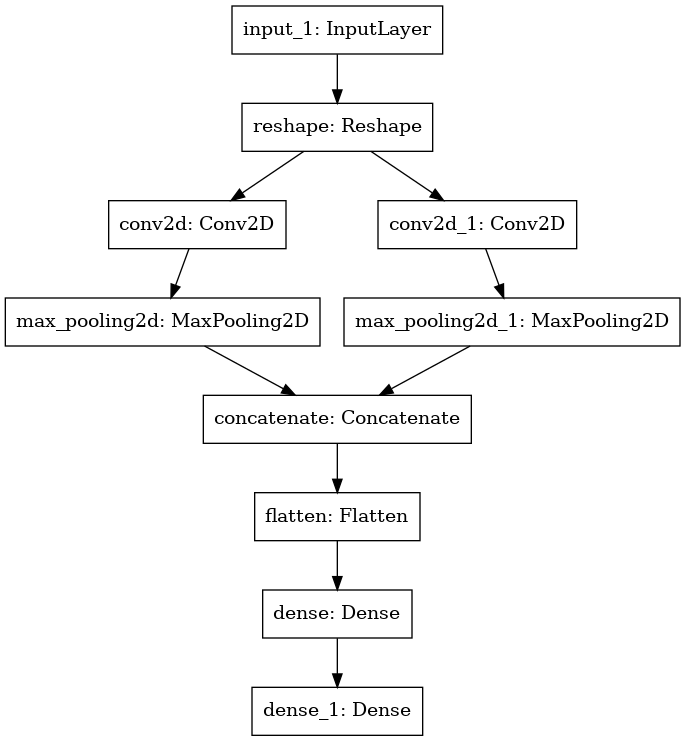

In [11]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
model.fit(x_train_v, y_train, epochs=10)

In [ ]:
model.evaluate(x_test_v, y_test)

# it fail with ram 